In [213]:
import numpy as np 
from scipy.integrate import quad,  dblquad
from sympy import symbols, integrate,hyper,  lambdify, sqrt
import pandas as pd
from matplotlib import pyplot as plt


G = 6.67e-8 # G const in cm^3/g/s^2
H0 = 69.8 * 1e5* 1000 # (km/s)/Mpc ->  (cm/s)/Mpc -> (cm/s)/Gpc 
pi = np.pi
c = 2.99e10 # in cm/s
Omega_m = 0.307
Omega_lambda = 1 - Omega_m
mu_path = "mu_k.csv"
M_solar = 1.989e+33 # mass in g

# Num = 0: merger, Num = 1: ringdown, Num = 2: sigma, Num = 3: cut
def mu_extract(num, nu,chi):
    df = pd.read_csv(mu_path, sep=',',header = 0)
    row_list = df.iloc[1].tolist()
    return 0
# Finish this part later, need to understand notation fully.
# For now we'll look into the test mass limit




def indefinite_integral(expression, variable):
    integral = integrate(expression, variable)
    integral_function = lambdify(variable, integral, modules="numpy")

    return integral, integral_function


# PBH Merger rate as a function of cosmic time
# m = pbh mass
# Eq) 32 in redshift paper
def R_0(m,f_pbh,t):
    S_eq = 0.005**2
    t0 = 13.8e9 # age of the universe, years
    M_0 = M_solar # keep input masses in solar mass
    R = 3.1*10**6*3.17098e-8**f_pbh**(53/37)*(t/t0)**(-34/37)*(m/M_0)**(-32/37)*0.24*(1+2.5*S_eq/f_pbh**2)**(-21/74)
    return R

# Takes single value of frequency and calculates dEdnu
def dEdnu(v_obs, m1,m2, chi,mu_merg, mu_ring, mu_cut,mu_sigma):

    M = m1+m2
    mu = m1*m2/M
    nu = mu/M
    # Chirp mass
    chirp = (m1*m2)**(3/5)/(m1+m2)**(1/5)
    # Coeffients for eq B.1 
    a2 = -323/224+451/156*nu
    a3 = (27/8-11/6*nu)*chi
    e1 = 1.4547*chi-1.8897
    e2= -1.8153*chi+1.6557
    v_prime = (pi*M*G*v_obs/c**3)**(1/3)

    # Values for freq cuttoffs
    v_merg = c**3/(pi*M*G)*(1-4.455*(1-chi)**(0.217) +3.521*(1-chi)**(0.26) + mu_merg)

    v_ring = c**3/(pi*M*G)*((1-0.63*(1-chi)**(0.3))/2 + mu_ring)

    v_cut = c**3/(pi*M*G)*(0.3236+0.04894*chi + 0.01346*chi**2 + mu_cut)

    sigma = c**3/(pi*M*G)*((1-0.63*(1-chi)**(0.3))*(1-chi)**(0.45)/4 + mu_sigma)

    z_max = v_cut/v_obs
    prefactor = (G*pi)**(2/3)*chirp**(5/3)/3
    # Values for f included only in loops that require them 
    # print(v_obs)
    # print(v_merg)
    # print(v_ring)
    # print(v_cut)
    dE = 0
    if v_obs < v_merg:

        f1 = 1 + a2*v_prime**2 + a3*v_prime**3
        dE = prefactor* v_obs**(-1/3)*f1 

    if v_merg <= v_obs < v_ring:

        f1 = 1 + a2*v_prime**2 + a3*v_prime**3
        f2 = 1 + e1*v_prime +e2*v_prime**2
        w1 = v_merg**-1*f1**2/f2**2
        dE = prefactor * w1*v_obs**(2/3)*f2**2


    if v_ring <= v_obs < v_cut:

        f1 = 1 + a2 * v_prime**2 + a3 * v_prime**3
        f2 = 1 + e1*v_prime +e2*v_prime**2
        f3 = v_obs/(1+(2*(v_obs-v_ring)/sigma)**2)

        w1 = v_merg**-1*f1**2/f2**2
        w2 = w1*v_ring**(-4/3)*f2**2
        
        dE = prefactor * w2 * f3**2
    # print("\n dE/dnu = {} \n ".format(dE))


    return z_max, dE, v_merg, v_ring, v_cut 

# Takes single value of frequency and calculates Omega for GW
def omega_GW(v_obs,m1,m2, chi,mu_merg, mu_ring, mu_cut,mu_sigma):
    Omega_gw = []
    f_pbh = 1 
    M = m1+m2
    mu = m1*m2/M
    nu = mu/M
    z = symbols('z') 
    # closure density
    p_c = 3*H0**2/(8*pi*G)

    E = sqrt(Omega_m*(1+z)**3 + Omega_lambda)
    integral_E, E_function = indefinite_integral(1/E, z)
    # comoving distance
    dc = c/H0*integral_E

    # luminosity distance
    dl = (1+z)*dc

    #Eq B.1 in appendix of SBGW paper
    z_max, energy_rate, v_merg, v_ring, v_cut = dEdnu(v_obs, m1,m2, chi,mu_merg, mu_ring, mu_cut, mu_sigma)

    #Eq 3) SBGW paper
    freq_v =  1/(4*pi*dl**2)*1/(1+z)*energy_rate
    
    dRdz = 4*pi*c/H0*dc**2/E*R_0(mu, f_pbh,13.8e9)

    integrand = lambdify(z,dRdz*freq_v)
    F_v,error  = quad(integrand, 0,z_max)
    # print(F_v)
    Omega_gw = v_obs/c**3/p_c*F_v
    return Omega_gw, v_merg, v_ring, v_cut
    



Frequencies: 
 v_merger = 7.44e+03 Hz
 v_ringdown = 1.1e+04 Hz
 v_cutoff = 1.21e+04 Hz


(1000, 100000)

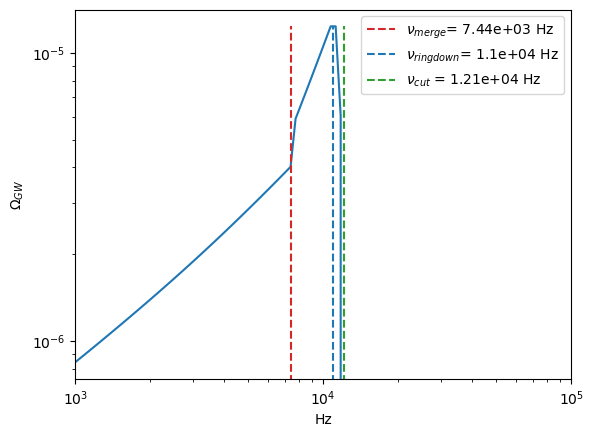

In [222]:

m1 = M_solar # Solar mass in grams
m2 = M_solar
v_obs = 0.2
chi = 0.9
mu_merg = 0
mu_ring = 0 
mu_cut = 0
mu_sigma = 0 

start_freq , stop_freq = 3,5
freq = np.logspace(start_freq, stop_freq, num=int(1e2), base=10.0, dtype=None, endpoint=True)

Omega = []

for f in freq:
    a, v_merg, v_ring, v_cut = omega_GW(f,m1,m2, chi,mu_merg, mu_ring, mu_cut,mu_sigma)
    Omega.append(a) 
print("Frequencies: \n v_merger = {:.3} Hz".format(v_merg) + "\n v_ringdown = {:.3} Hz".format(v_ring) + "\n v_cutoff = {:.3} Hz".format(v_cut))
    
plt.plot(freq,Omega)
plt.xlabel('Hz')
plt.ylabel('$\\Omega_{GW}$')
plt.yscale('log')
plt.xscale('log')
plt.vlines(v_merg,0,max(Omega), color = 'tab:red',linestyle='--', label = r"$\nu_{merge}$" + "= {:.3} Hz".format(v_merg))
plt.vlines(v_ring,0,max(Omega),color = 'tab:blue',linestyle='--', label = r"$\nu_{ringdown}$" + "= {:.3} Hz".format(v_ring))
plt.vlines(v_cut,0,max(Omega),color = 'tab:green',linestyle='--', label = r"$\nu_{cut}$" + " = {:.3} Hz".format(v_cut))
plt.legend()
plt.xlim(10**(start_freq),10**(stop_freq))

Frequencies, $\chi$ = 0.9:  
 v_merger = 7.44e+02 Hz
 v_ringdown = 1.1e+03 Hz
 v_cutoff = 1.21e+03 Hz


(10, 10000)

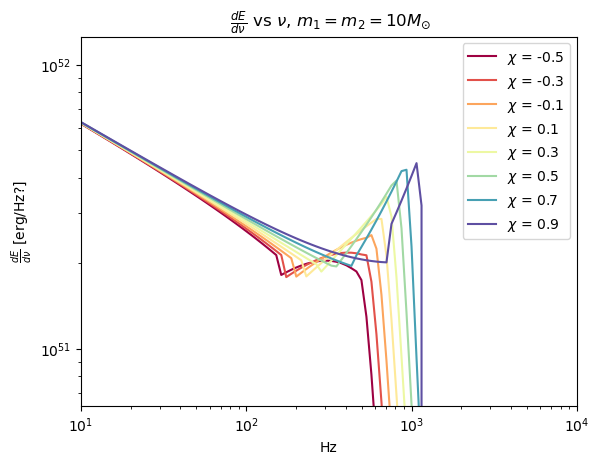

In [203]:

m1 = 10*M_solar # Solar mass in grams
m2 = 10*M_solar
chi =np.linspace(-0.5, 0.9, 8)
chi = [round(i,1) for i in chi]
colors = plt.cm.Spectral(np.linspace(0, 1, len(chi)))
mu_merg = 0
mu_ring = 0 
mu_cut = 0
mu_sigma = 0 

start_freq , stop_freq = 1,4
freq = np.logspace(start_freq, stop_freq, num=int(1e2), base=10.0, dtype=None, endpoint=True)


for j,k in enumerate(chi):
    dEdn = []
    f_axis = []

    for f in freq:
        zmax,a, v_merg, v_ring, v_cut = dEdnu(f,m1,m2, k,mu_merg, mu_ring, mu_cut,mu_sigma)
        if a == "NaN": 
            pass
        else:
            dEdn.append(a) 
            f_axis.append(f)
    plt.plot(f_axis,dEdn, label = "$\chi$ = {}".format(k), color = colors[j])
print("Frequencies, $\chi$ = {:.1}".format(chi[j]) + ":  \n v_merger = {:.3} Hz".format(v_merg) + "\n v_ringdown = {:.3} Hz".format(v_ring) + "\n v_cutoff = {:.3} Hz".format(v_cut))

plt.title(" $\\frac{dE}{d\\nu}$ vs $\\nu$, $m_1 = m_2 = 10 M_{\odot}$ ")
plt.xlabel('Hz')
plt.ylabel('$\\frac{dE}{d \\nu}$ [erg/Hz?]')
plt.xscale('log')
plt.yscale('log')
# plt.vlines(v_merg,0,max(dEdn), color = 'tab:red',linestyle='--', label = "$\\nu_m$ = {:.3} Hz".format(v_merg))
# plt.vlines(v_ring,0,max(dEdn),color = 'tab:blue',linestyle='--', label = "$\\nu_r$ = {:.3} Hz".format(v_ring))
# plt.vlines(v_cut,0,max(dEdn),color = 'tab:green',linestyle='--', label = "$\\nu_c$ = {:.3} Hz".format(v_cut))
plt.legend()
plt.ylim(max(dEdn)/1e1,max(dEdn)*2)
plt.xlim(10**(start_freq),10**(stop_freq))
